# Image classification: cats & dogs

In [1]:
# Handle imports up-front
import glob
import random
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image

## 1. Data preparation

### 1.1. Load the data paths

In [2]:
# Set the path to the training data
training_data_path='../data/train'

# Get a list of training dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dog/dog.*')
training_cats=glob.glob(f'{training_data_path}/cat/cat.*')

### 1.2. Inspect

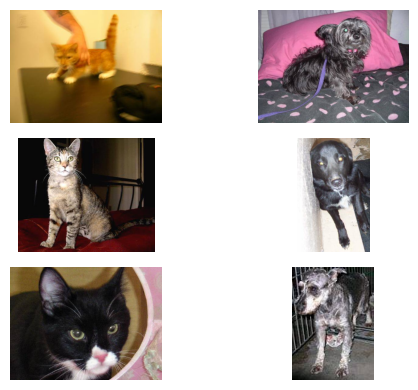

In [3]:
fig, axs = plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 2. EDA

Let's take a look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [4]:
# Load one of the dogs
dog=image.load_img(training_dogs[0])

# And convert it to an array - this is how TensorFlow will handel the data
dog=image.img_to_array(dog)

# Take a look at some properties of the object
print(f'Image data is: {type(dog)}')
print(f'Image data shape: {dog.shape}')

Image data is: <class 'numpy.ndarray'>
Image data shape: (375, 499, 3)


The data has shape of 375 x 499 x 3? So, the image is 375 x 499 pixels, but what is the 3? Let's plot the pixel values and you will see what is going on:

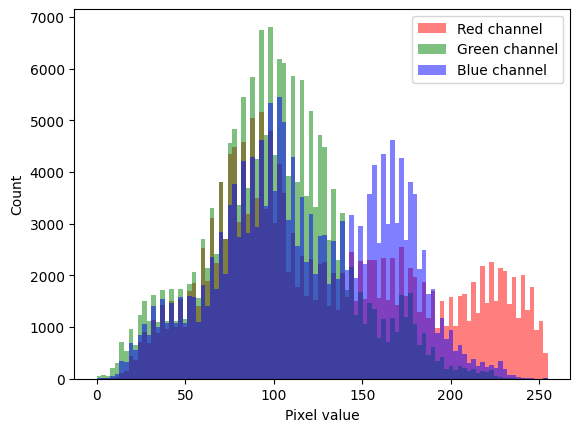

In [5]:
plt.hist(dog[:,:,0].flatten(), bins=100, color='red', alpha=0.5, label='Red channel')
plt.hist(dog[:,:,1].flatten(), bins=100, color='green', alpha=0.5, label='Green channel')
plt.hist(dog[:,:,2].flatten(), bins=100, color='blue', alpha=0.5, label='Blue channel')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

There are a few interesting observations we can make here:

1. This array has 3 axes: 375 x 499 x 3. The first two are the dimensions of the image, the third is the three color channels: red, green and blue.
2. 375 x 499 x 3 is over a half million individual values - this one image is 10 time more data that any of the other datasets we have worked with so far!
3. The range of pixel values is from 0 to about 250 - in reality it is (0,255) for a total range of 256 values per pixel. This is defined by the JPEG image standard.

There are two things we can do with this information. First, we should scale to pixel values, this will improve the training of our neural network. We can do this directly in the model definition by adding a normalization layer. Second, we can make the images gray scale, which will decrease the input size and therefore computational burden by a factor of three. We can do this via the image dataset generator.

### 2.2. Image dimensions

Let's take a look at a random sample of images from the dataset and see what their dimensions are.

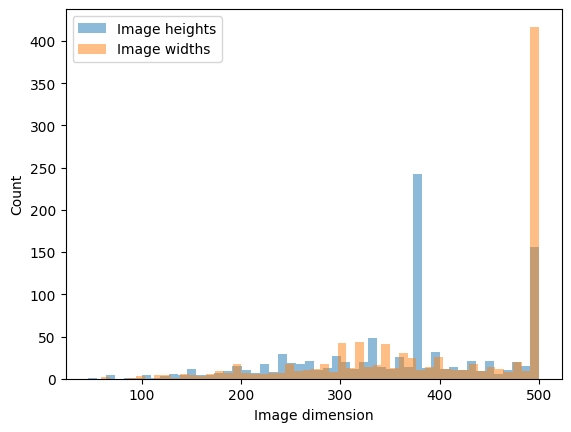

In [6]:
sample_size=1000
sample=random.sample(training_dogs, sample_size//2)
sample+=random.sample(training_cats, sample_size//2)

heights=[]
widths=[]

for sample_image in sample:

    sample_image=image.load_img(sample_image)
    sample_image=image.img_to_array(sample_image)
    heights.append(sample_image.shape[0])
    widths.append(sample_image.shape[1])

plt.hist(heights, bins=50, alpha=0.5, label='Image heights')
plt.hist(widths, bins=50, alpha=0.5, label='Image widths')
plt.xlabel('Image dimension')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

Based on the above plot, let's set our image dimension at 128x128. Smaller is better for training speed and memory use, but we don't want to go too small, then the model will have a hard time learning from the data. There is no hard and fast rule here. You could do an experiment testing several different image dimensions to see how small we could make the image and still get good performance.

In [7]:
image_dim=128

### 2.3. Image aspect ratios

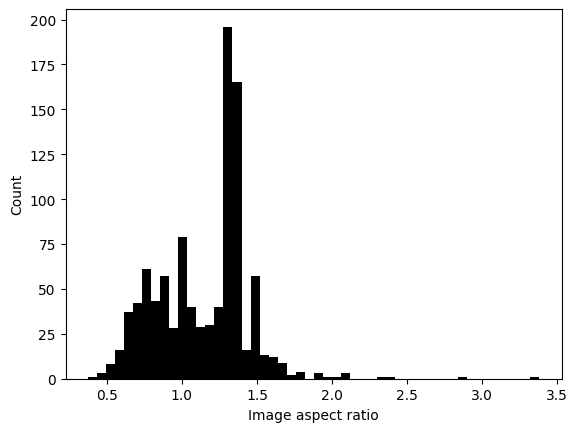

In [8]:
aspect_ratios=np.array(widths)/np.array(heights)

plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

The most common aspect ratio in the data set looks to be arround 1.3 - its the '4:3' aspect ratio that used to be the standard for computer monitors. Ranther than using square input images, we can use this aspect ratio to better match the data.

In [9]:
image_width=image_dim
image_height=int(image_dim / (4/3))
print(f'Image input dimensions: {image_width} x {image_height}')

Image input dimensions: 128 x 96


## 2. Model

### 2.1. Prepare images for streaming

In [10]:
def make_datasets(training_data_path, image_width, image_height, batch_size: int=32):

    training_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='training',
        seed=315,
        image_size=(image_width, image_height),
        color_mode='grayscale',
        batch_size=batch_size
    )

    validation_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='validation',
        seed=315,
        image_size=(image_width, image_height),
        color_mode='grayscale',
        batch_size=batch_size
    )

    return training_dataset, validation_dataset

training_dataset, validation_dataset=make_datasets(training_data_path, image_width, image_height)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


### 2.1. Model definition

In [12]:
def compile_model(training_dataset, image_width, image_height, learning_rate):

    # Define and adapt a normalization layer this step calculates the 
    # mean and standard deviation that will be used to normalize the data
    sample_data=training_dataset.take(1000)
    adapt_data=sample_data.map(lambda x, y: x)

    norm_layer=tf.keras.layers.Normalization()
    norm_layer.adapt(adapt_data)

    initializer=tf.keras.initializers.GlorotUniform(seed=315)

    model=Sequential([
        layers.Input((image_width, image_height, 1)),
        norm_layer,
        layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

    return model

model=compile_model(training_dataset, image_width, image_height, 0.001)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 128, 96, 1)        3         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 128, 96, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 48, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 48, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 24, 32)        0         
 g2D)                                                            
                                                        

### 2.2. Model training

In [ ]:
training_results=model.fit(
  training_dataset.repeat(),
  validation_data=validation_dataset.repeat(),
  epochs=10,
  steps_per_epoch=50,
  validation_steps=50
)

Epoch 1/10
5/5 [==============================] - 2s 162ms/step - loss: 0.9686 - binary_accuracy: 0.5250 - val_loss: 0.7446 - val_binary_accuracy: 0.4812
Epoch 2/10
5/5 [==============================] - 1s 112ms/step - loss: 0.6981 - binary_accuracy: 0.5437 - val_loss: 0.6935 - val_binary_accuracy: 0.5188
Epoch 3/10
5/5 [==============================] - 1s 111ms/step - loss: 0.6923 - binary_accuracy: 0.5000 - val_loss: 0.6914 - val_binary_accuracy: 0.5500
Epoch 4/10
5/5 [==============================] - 1s 111ms/step - loss: 0.6875 - binary_accuracy: 0.5813 - val_loss: 0.6871 - val_binary_accuracy: 0.5437
Epoch 5/10
5/5 [==============================] - 0s 107ms/step - loss: 0.6960 - binary_accuracy: 0.4688 - val_loss: 0.6874 - val_binary_accuracy: 0.6000
Epoch 6/10
5/5 [==============================] - 0s 105ms/step - loss: 0.6791 - binary_accuracy: 0.6438 - val_loss: 0.6845 - val_binary_accuracy: 0.5625
Epoch 7/10
5/5 [==============================] - 0s 108ms/step - loss: 0.69

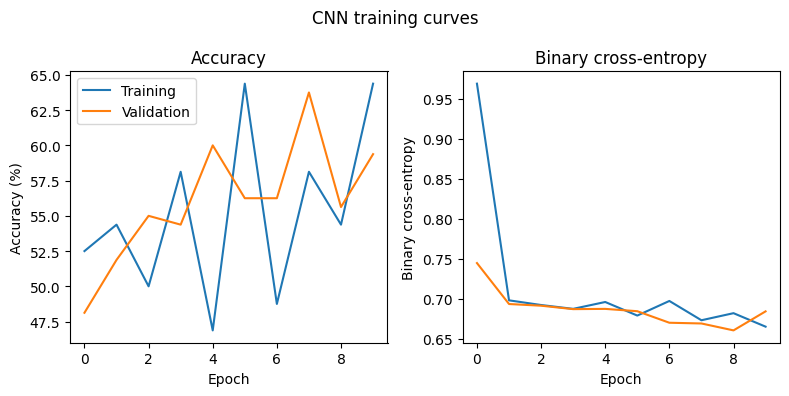

In [14]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_results.history['binary_accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_results.history['val_binary_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_results.history['loss'])
axs[1].plot(training_results.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

# Show the plot
plt.tight_layout()
plt.show()

### 2.3. Model optimization

In [19]:
learning_rates=[0.001,0.0001,0.00001]
batch_sizes=[64,128,256]
training_results=[]

conditions=list(itertools.product(batch_sizes, learning_rates))

for i, parameters in enumerate(conditions):

    batch_size, learning_rate=parameters

    print(f'\nStarting training run {i + 1} of {len(learning_rates) * len(batch_sizes)}: batch size: {batch_size}, learning rate: {learning_rate}')

    training_dataset, validation_dataset=make_datasets(training_data_path, image_width, image_height, batch_size)
    model=compile_model(training_dataset, image_width, image_height, learning_rate)

    early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

    training_result=model.fit(
        training_dataset.repeat(),
        validation_data=validation_dataset.repeat(),
        epochs=10,
        steps_per_epoch=20,
        validation_steps=20,
        callbacks=[early_stopping]
    )

    training_results.append(training_result)


Starting training run 1 of 9: batch size: 64, learning rate: 0.001
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Epoch 1/10
20/20 [==============================] - 5s 180ms/step - loss: 0.7775 - binary_accuracy: 0.4977 - val_loss: 0.6888 - val_binary_accuracy: 0.5555
Epoch 2/10
20/20 [==============================] - 3s 170ms/step - loss: 0.6806 - binary_accuracy: 0.5703 - val_loss: 0.6743 - val_binary_accuracy: 0.5805
Epoch 3/10
20/20 [==============================] - 3s 170ms/step - loss: 0.6670 - binary_accuracy: 0.5961 - val_loss: 0.6362 - val_binary_accuracy: 0.6477
Epoch 4/10
20/20 [==============================] - 3s 170ms/step - loss: 0.6272 - binary_accuracy: 0.6539 - val_loss: 0.6223 - val_binary_accuracy: 0.6539
Epoch 5/10
20/20 [==============================] - 3s 170ms/step - loss: 0.6069 - binary_accuracy: 0.6750 - val_loss: 0.5966 - val_binary_accuracy: 0.6906
Epo

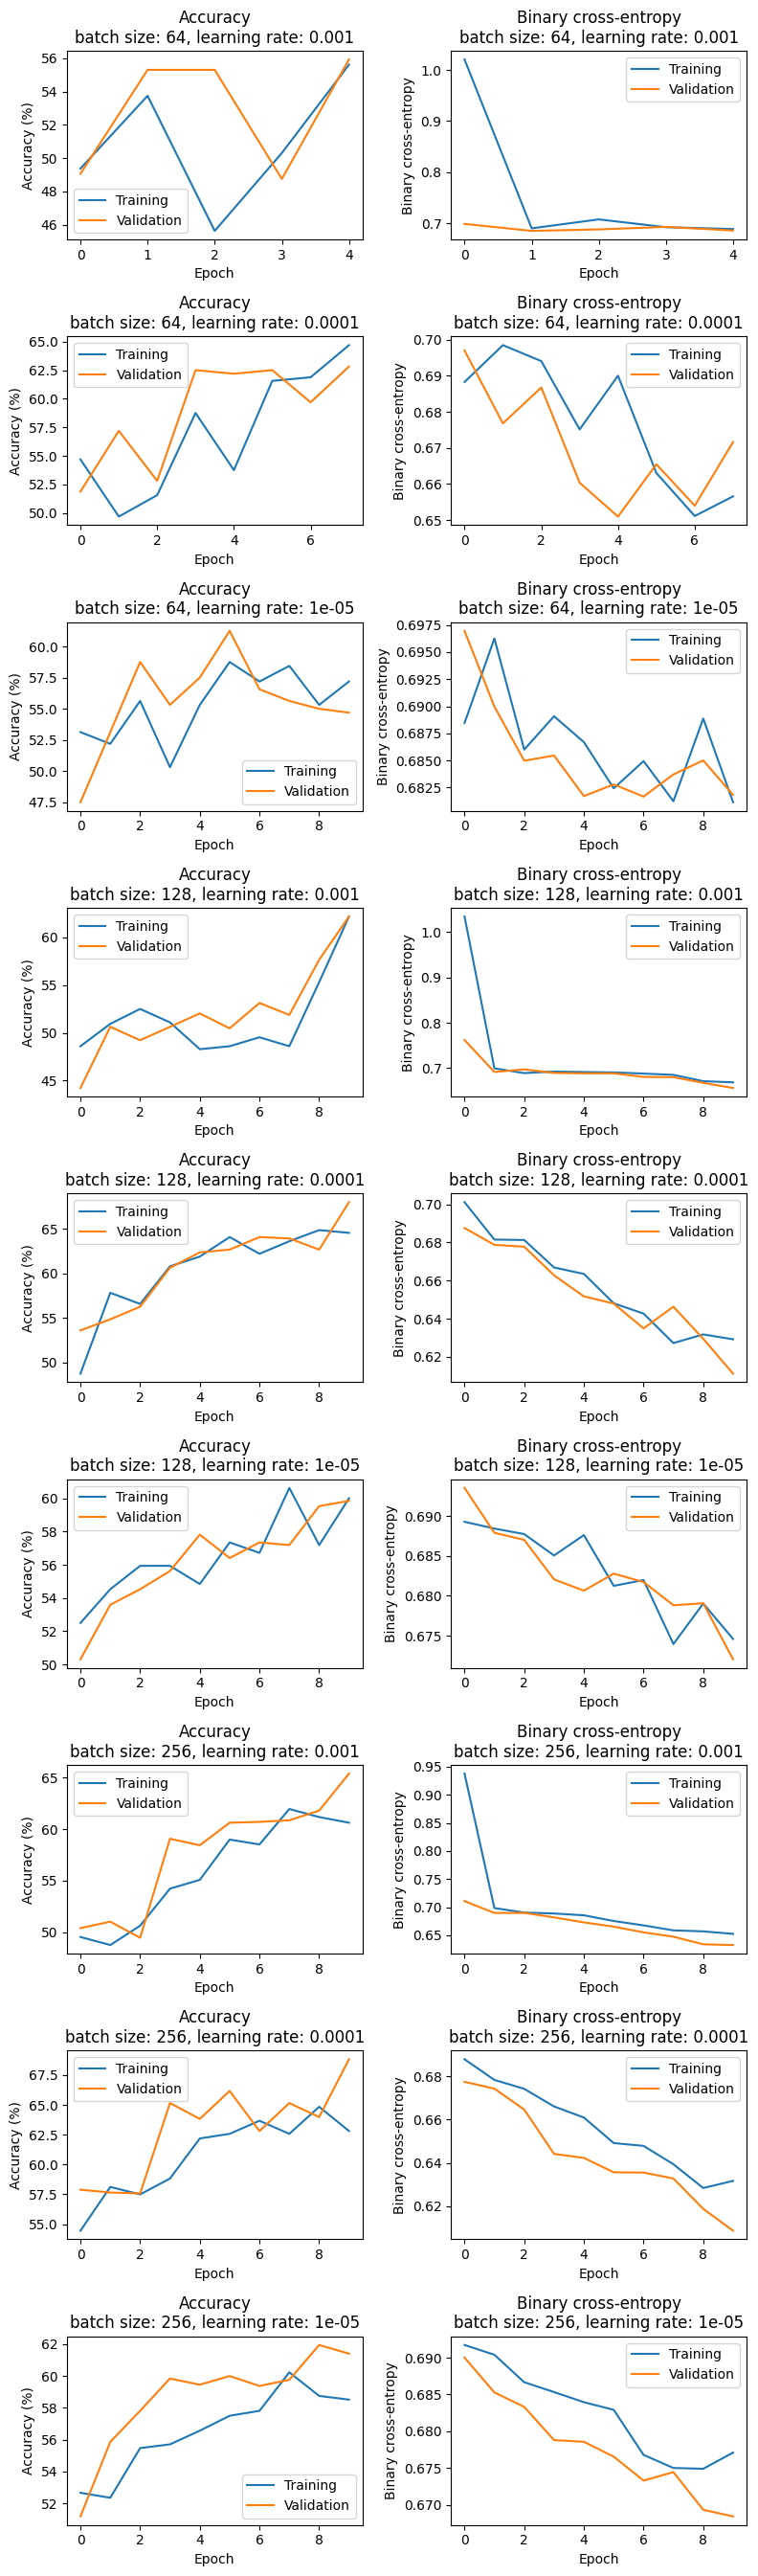

In [18]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(len(training_results), 2, figsize=(8,3*len(training_results)))

# Plot the results of each training run
for i, parameters in enumerate(conditions):
    batch_size, learning_rate=parameters
    training_result=training_results[i]

    # Plot training and validation accuracy
    axs[i,0].set_title(f'Accuracy\nbatch size: {batch_size}, learning rate: {learning_rate}')
    axs[i,0].plot(np.array(training_result.history['binary_accuracy']) * 100, label='Training')
    axs[i,0].plot(np.array(training_result.history['val_binary_accuracy']) * 100, label='Validation')
    axs[i,0].set_xlabel('Epoch')
    axs[i,0].set_ylabel('Accuracy (%)')
    axs[i,0].legend(loc='best')

    # Plot training and validation binary cross-entropy
    axs[i,1].set_title(f'Binary cross-entropy\nbatch size: {batch_size}, learning rate: {learning_rate}')
    axs[i,1].plot(training_result.history['loss'], label='Training')
    axs[i,1].plot(training_result.history['val_loss'], label='Validation')
    axs[i,1].set_xlabel('Epoch')
    axs[i,1].set_ylabel('Binary cross-entropy')
    axs[i,1].legend(loc='best')

# Show the plot
plt.tight_layout()
plt.show()

From the training curves, it looks like the best results are obtained with a batch size of 256 and a learning rate of 0.001. We can also try running more steps per epoch and more validation steps. That will slow the training down, but may help smooth the curves out somewhat. Let's use those settings and train the model for longer.

In [ ]:
batch_size=128
learning_rate=0.001
epochs=100
steps_per_epoch=20
validation_steps=10

training_dataset, validation_dataset=make_datasets(training_data_path, image_dim, batch_size)
model=compile_model(image_dim, learning_rate)

early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

training_result=model.fit(
    training_dataset.repeat(),
    validation_data=validation_dataset.repeat(),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

In [ ]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_result.history['binary_accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_result.history['val_binary_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_result.history['loss'])
axs[1].plot(training_result.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

# Show the plot
plt.tight_layout()
plt.show()